### Standard Lib Imports

In [1]:
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parent)

In [2]:
from src import config
from src.helper import *

### Load Data
For this notebook, we will load in all the datasets and combine and compare them.

In [3]:
fnames = [f for f in os.listdir(config.DATA_PATH) if f.endswith('.csv')]
fnames.sort()

In [4]:
fnames

['Availability.csv',
 'Prices.csv',
 'Product Details.csv',
 'Purchase.csv',
 'Sales.csv',
 'Visits on PDP.csv']

In [5]:
data = []

for fname in fnames:
    data.append(read_data(fname))

In [6]:
# Separate into individual dataframes 

availability = data[0]
prices = data[1]
product_details = data[2]
purchase = data[3]
sales = data[4]
visits_on_pdp = data[5]

del data

In [7]:
# Correct column name in Product Details dataframe
product_details = product_details.rename({'product_id*31': 'product_id'}, axis=1)

In [73]:
sales['date'] = pd.to_datetime(sales['date'])
purchase['date'] = pd.to_datetime(purchase['date'])
visits_on_pdp['date'] = pd.to_datetime(visits_on_pdp['date'])
availability['date'] = pd.to_datetime(availability['date'])

### Understanding Page Visits vs. Sales

In [9]:
visits_sales = sales.merge(visits_on_pdp, on=['date', 'product_id'], how='left')#.fillna(0)

In [10]:
visits_sales.loc[:, 'visits'] = visits_sales.loc[:, 'visits'].fillna(0).astype(int)
visits_sales = visits_sales.rename({'quantity': 'sales'}, axis=1)

In [11]:
visits_sales.head()

,date,product_id,sales,visits
0,2020-11-30,326726608,1,1
1,2020-01-06,334009500,4,31
2,2020-08-17,334009500,2,16
3,2020-03-17,334009500,1,29
4,2020-09-21,334009500,1,23


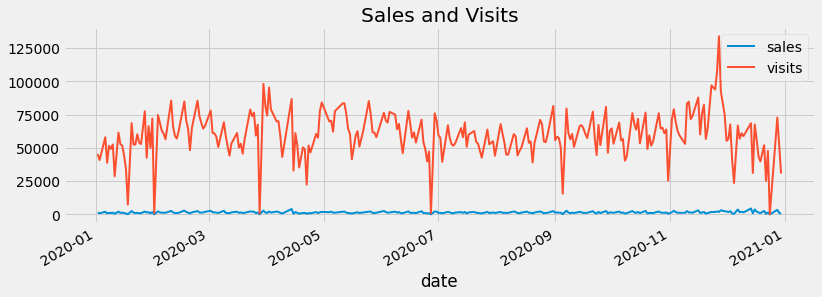

In [12]:
visits_sales.groupby('date')[['sales', 'visits']].sum().plot(linewidth=config.lw, figsize=(config.FIGSIZE))
plt.title('Sales and Visits');

In [13]:
scaler = StandardScaler()
visits_sales['sales_scaled'] = scaler.fit_transform(visits_sales.loc[:, ['sales']])
visits_sales['visits_scaled'] = scaler.fit_transform(visits_sales.loc[:, ['visits']])

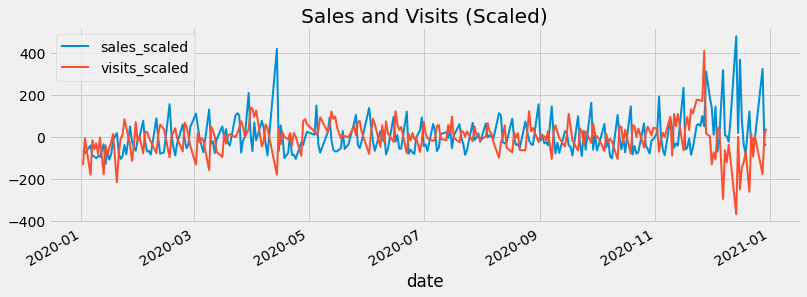

In [14]:
visits_sales.groupby('date')[['sales_scaled', 'visits_scaled']].sum()\
    .plot(linewidth=config.lw, figsize=(config.FIGSIZE))
plt.title('Sales and Visits (Scaled)');

In [15]:
visits_sales_corr = np.corrcoef(visits_sales['sales'], visits_sales['visits'])[0, 1]

In [16]:
print(f"The correlation between page visits and sales: {round(visits_sales_corr, 2)}")

The correlation between page visits and sales: 0.54


We see that page visits and sales of that particular product are quite correlated.

Let's just take a look at the visits data

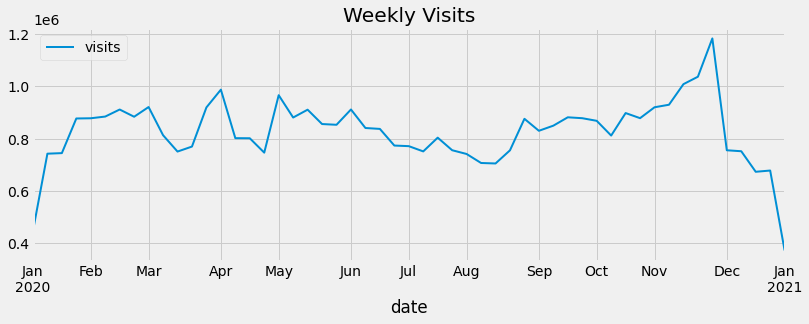

In [19]:
plot_ts_data(visits_on_pdp.set_index('date').drop('product_id', axis=1), 
             plot_daily=False, plot_weekly=True, title='Visits')

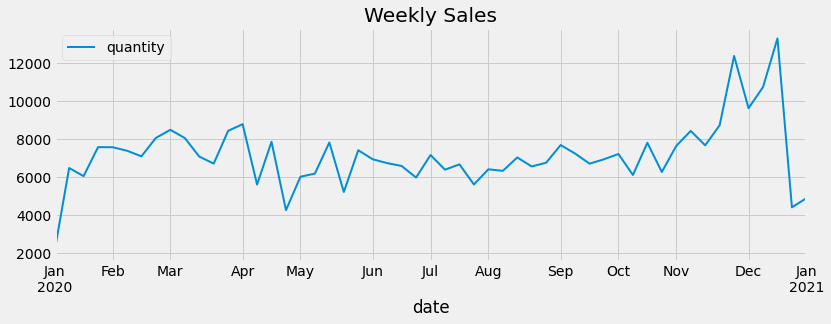

In [20]:
plot_ts_data(sales.set_index('date').drop('product_id', axis=1),
             plot_daily=False, plot_weekly=True, title='Sales')

- We see something interesting in December here. The page visit count has gone down, whereas the sales have gone up. 

#### Sales across categories

In [93]:
sales_products = sales.merge(product_details, on=['product_id'], how='left')

Monthly Sales

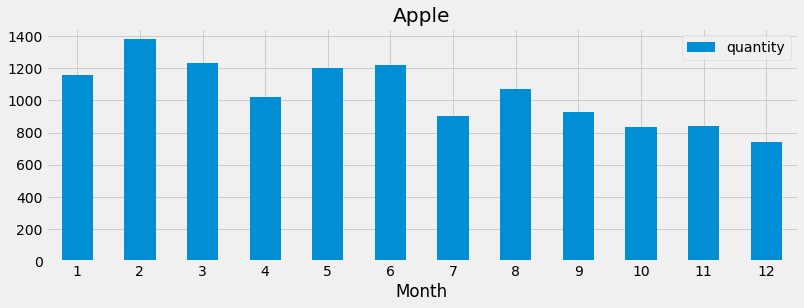

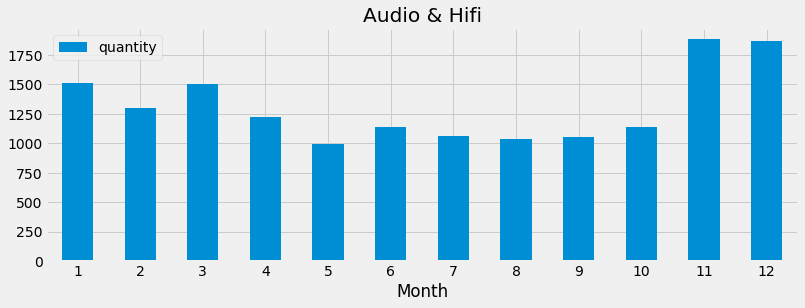

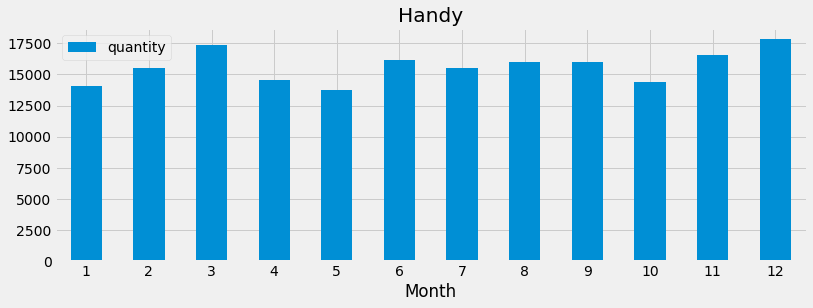

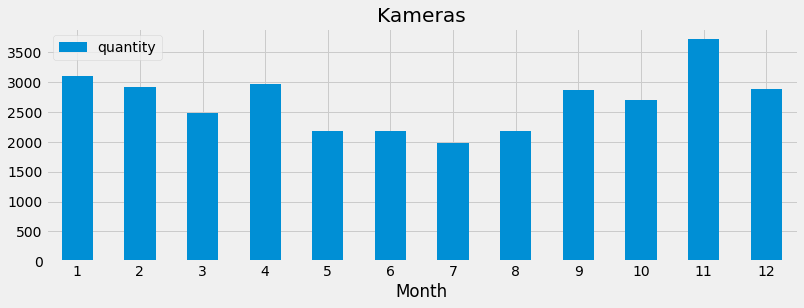

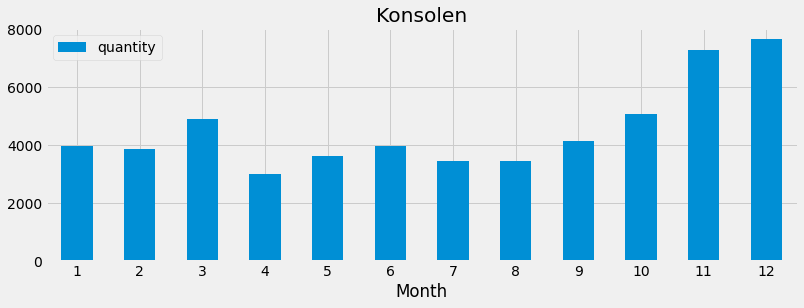

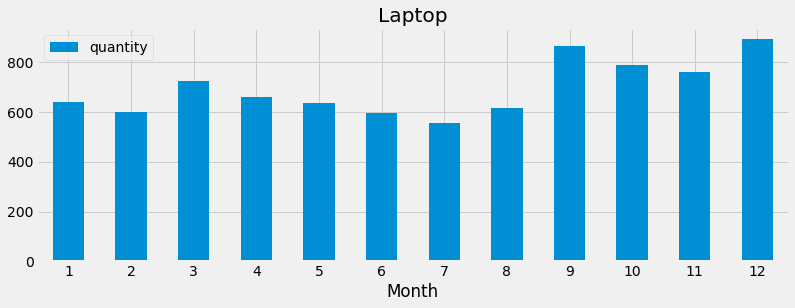

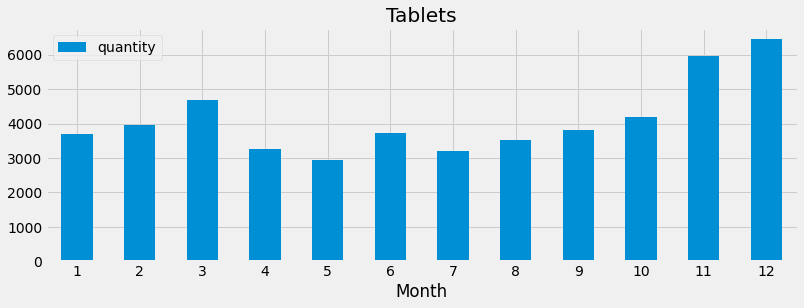

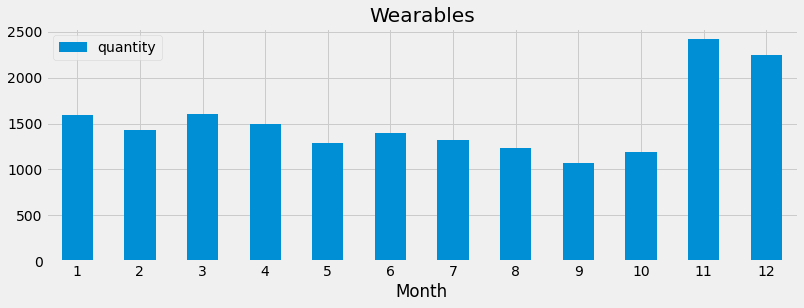

In [133]:
sales_products_agg = sales_products.set_index('date').groupby('main_category').resample('M')['quantity']\
    .sum().reset_index()

for category in sales_products_agg['main_category'].unique():
    x = sales_products_agg[sales_products_agg['main_category'] == category]
    x = x.drop('main_category', axis=1)
    x = x.set_index('date')
    x.plot(linewidth=config.lw, figsize=config.FIGSIZE, kind='bar')
    plt.xticks(ticks=range(len(x)), labels=x.index.month, rotation=0)
    plt.xlabel('Month')
    plt.title(category);

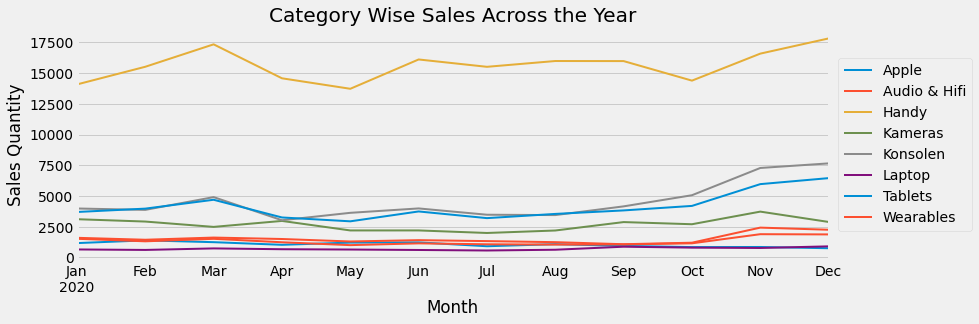

In [149]:
sales_products_agg.pivot(index='date', columns='main_category', values='quantity')\
    .plot(linewidth=config.lw, figsize=config.FIGSIZE)
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('Category Wise Sales Across the Year')
plt.xlabel('Month')
plt.ylabel('Sales Quantity');

**Visits by Category**

In [152]:
visits_products = visits_on_pdp.merge(product_details, on='product_id', how='left')
visits_products_agg = visits_products.set_index('date').groupby('main_category').resample('M')['visits']\
    .sum().reset_index()

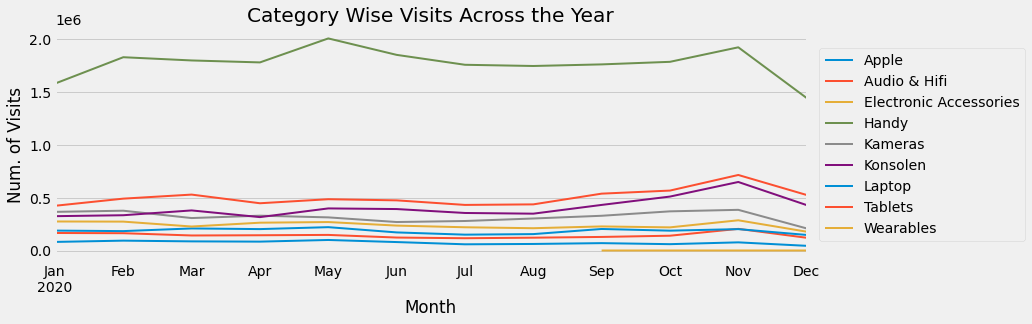

In [155]:
visits_products_agg.pivot(index='date', columns='main_category', values='visits')\
    .plot(linewidth=config.lw, figsize=config.FIGSIZE)
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.title('Category Wise Visits Across the Year')
plt.xlabel('Month')
plt.ylabel('Num. of Visits');

Let's calculate the conversion ratio as: sales/visits

In [23]:
visits_sales = visits_sales.set_index('date')

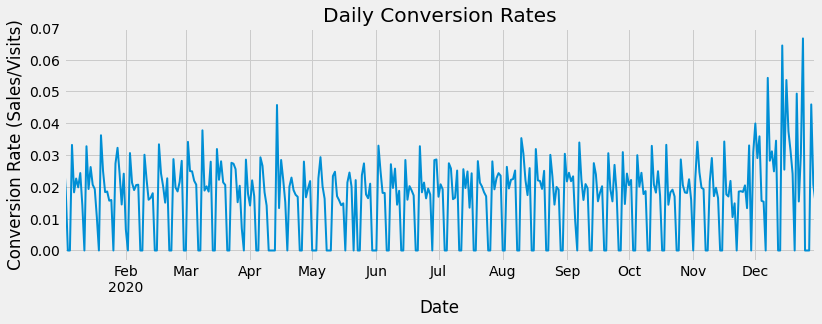

In [89]:
conv_rate = visits_sales.resample('D')['sales', 'visits'].sum()
conv_rate['cvr'] = (conv_rate['sales']/conv_rate['visits']).fillna(0)
conv_rate['cvr'].plot(lw=config.lw, figsize=config.FIGSIZE)
plt.title('Daily Conversion Rates')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (Sales/Visits)');

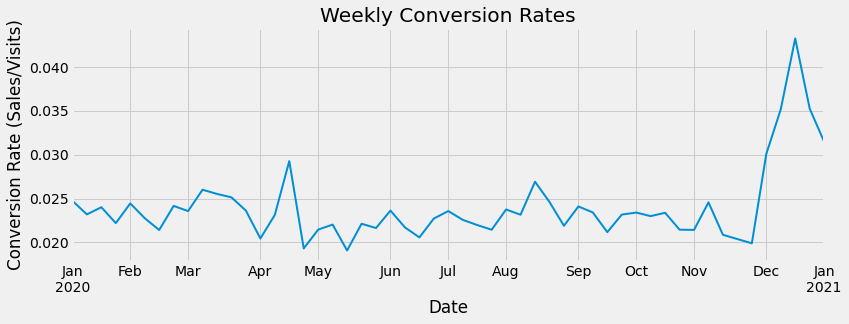

In [88]:
conv_rate = visits_sales.resample('W')['sales', 'visits'].sum()
conv_rate['cvr'] = (conv_rate['sales']/conv_rate['visits']).fillna(0)
conv_rate['cvr'].plot(lw=config.lw, figsize=config.FIGSIZE)
plt.title('Weekly Conversion Rates')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (Sales/Visits)');

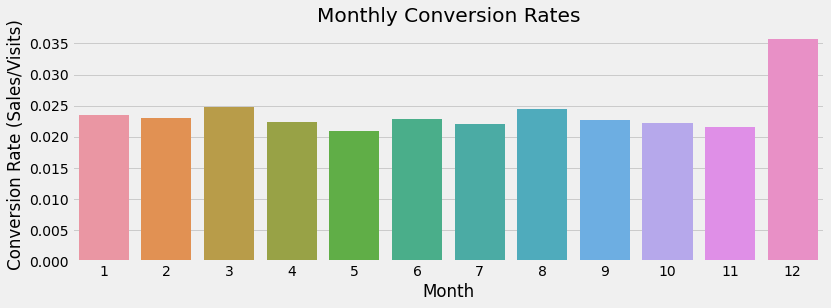

In [156]:
conv_rate = visits_sales.resample('M')['sales', 'visits'].sum()
conv_rate['cvr'] = (conv_rate['sales']/conv_rate['visits']).fillna(0)
plt.figure(figsize=config.FIGSIZE)
sns.barplot(data=conv_rate.reset_index(), x='date', y='cvr')
plt.xticks(ticks=range(12), labels=conv_rate.index.month)
plt.xlabel('Month')
plt.ylabel('Conversion Rate (Sales/Visits)')
plt.title('Monthly Conversion Rates');

We see that on average, the conversion rate is around 2.5% but during December the conversion rate jumps up to 3.5% (A 40% increase in conversion)

### Availability Rates and Sales

In [71]:
availability = availability.fillna(0)

In [75]:
sales_availability = sales.merge(availability, on=['product_id', 'date'], how='left').fillna(0)

Let's try to understand the correlation of sales quantity with the availability rates of different variants.

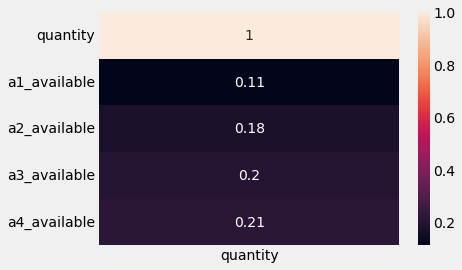

In [86]:
sns.heatmap(sales_availability.drop('product_id', axis=1).corr().loc[['quantity']].transpose(), annot=True);

We see that sales quantity is almost equally correlated with the availability rates of A2, A3 and A4 but not so much with A1. 